In [2]:
import pandas as pd
from types import MethodType

def summary(self: pd.DataFrame, categorical_columns, numerical_columns):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    for col in categorical_columns:
        unique_counts = self[col].value_counts()
        
        print(f"Number of unique values in [{col}]: {len(unique_counts)}")
        print(f"Unique values in [{col}]:")
        print(unique_counts)
        print()
        plt.figure(figsize=(7,5))
        plt.bar(unique_counts.index, unique_counts)
        plt.title(f"Counts of unique values in {col}")
        print()
        
    for col in numerical_columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        sns.boxplot(x=self[col], ax=ax1)
        ax1.set_title(f"Box plot for the values in {col}")

        ax2.hist(self[col])
        ax2.set_title(f"Histogram for the values in {col}")

        plt.tight_layout()
        plt.show()
        

def null_values(self: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns
        
    plt.figure(figsize=(15,10))
    sns.heatmap(self.isna(), cmap='coolwarm')
    plt.show()
    

def sin_cos_transformation(self: pd.DataFrame, date_columns, periods):
    import numpy as np
    import pandas as pd
    
    for col in date_columns:
        date = pd.to_datetime(self[col])
        day_of_year = date.dt.dayofyear
        angle = 2 * np.pi * day_of_year / periods
        
        self[f'day_sin_{col}'] = np.sin(angle)
        self[f'day_cos_{col}'] = np.cos(angle)
        
        self.drop(columns=col, inplace=True)
    
    
def correlation_matrix(self: pd.DataFrame, numerical_columns):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    df = self[numerical_columns]
    
    corr_matrix = df.corr()

    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, 
                annot=True,
                cmap='coolwarm',
                vmin=-1, vmax=1)

    plt.title('Correlation Matrix')
    plt.show()
    

def confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    

def add_summary_method(df: pd.DataFrame):
    df.summary = MethodType(summary, df)
    

def add_null_values_method(df: pd.DataFrame):
    df.null_values = MethodType(null_values, df)


def add_sin_cos_transformation_method(df: pd.DataFrame):
    df.sin_cos_transformation = MethodType(sin_cos_transformation, df)
    
    
def add_correlation_matrix_method(df: pd.DataFrame):
    df.correlation_matrix = MethodType(correlation_matrix, df)

In [3]:
import requests
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
import xgboost as xgb
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from itertools import product
from typing import Dict
import scipy.stats as stats
import statsmodels.api as sm



warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_alpha_vantage_data(symbol, api_key):
    base_url = 'https://www.alphavantage.co/query'
    function = 'TIME_SERIES_DAILY'
    
    params = {
        'function': function,
        'symbol': symbol,
        'apikey': api_key,
        'outputsize': 'full'
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if 'Time Series (Daily)' not in data:
        print("Error: ", data.get('Error Message', 'Unknown error'))
        return None

    return data['Time Series (Daily)']




api_key = 'LDS6QLMELH5AYPSI'
symbol = 'SO'  

historical_data = get_alpha_vantage_data(symbol, api_key)

In [4]:
df_hist = pd.DataFrame(historical_data)
df_hist = df_hist.transpose()
df_hist

,1. open,2. high,3. low,4. close,5. volume
2025-02-21,87.5500,88.9800,87.1000,88.4000,5348097
2025-02-20,84.5000,89.0000,84.5000,87.8200,9109236
2025-02-19,86.0000,86.6100,85.3800,86.4800,5049856
2025-02-18,84.9000,85.9000,84.6700,85.8900,4207609
2025-02-14,87.0200,87.4800,85.4800,85.5800,4391036
...,...,...,...,...,...
1999-11-05,26.1300,26.5000,26.0600,26.1300,2500200
1999-11-04,26.1900,26.5600,25.8100,25.8800,1786700
1999-11-03,26.3800,26.4400,26.0600,26.1900,1817300
1999-11-02,26.4400,26.7500,26.3800,26.3800,1385900


In [5]:
volume = df_hist['5. volume'][::-1].astype(int)
close = df_hist['4. close'][::-1].astype(float)

<Axes: ylabel='5. volume'>

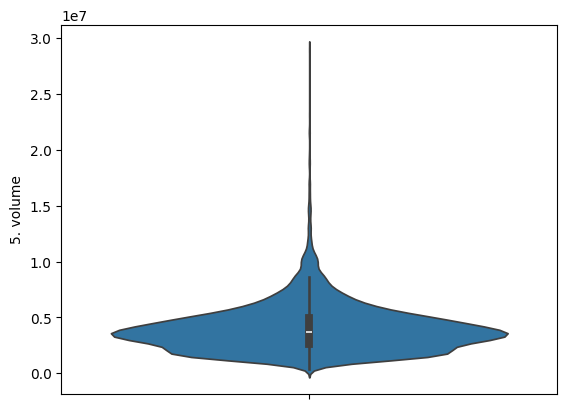

In [6]:
sns.violinplot(volume)

<Axes: ylabel='5. volume'>

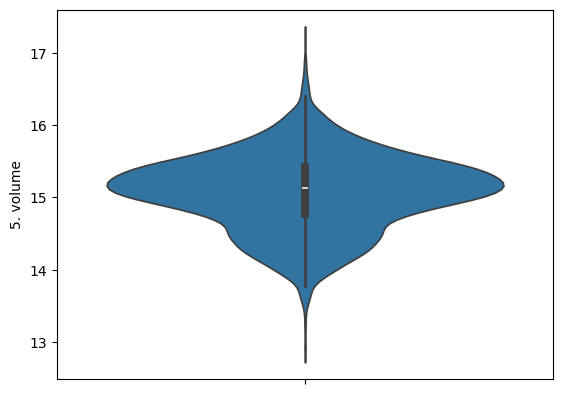

In [7]:
sns.violinplot(np.log(volume))

THE LOG TRANSFORMED VALUE DEALS MUCH BETTER WITH OUTLIERS

In [8]:
volume = np.log(volume)

In [9]:
# Since the stock price displays linear growth, a differencing order of 1 is enough

print("The p-value for the adfuller test on the (differentiated) closing prices is: ", adfuller(close.diff().dropna())[1])

The p-value for the adfuller test on the (differentiated) closing prices is:  0.0


In [10]:
import itertools

# Testing multiple autoregressive and moving average orders and compare berformance. 

p_values = [0, 1, 2, 3, 4, 5] 
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5] 

results_list = []

for p, d, q in itertools.product(p_values, d_values, q_values):
    model = sm.tsa.ARIMA(list(close), order=(p, d, q))
    model_fit = model.fit()
    
    # Only add AIC and BIC values if convergence is successful.
    if model_fit.mle_retvals['converged']:
        aic = round(model_fit.aic, 2)
        bic = round(model_fit.bic, 2)
        results_list.append((p, d, q, aic, bic))

results_df = pd.DataFrame(results_list, columns=['p', 'd', 'q', 'aic', 'bic'])

C:\Users\Darius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Darius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Darius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

In [11]:
results_df.sort_values(by='aic').head()

,p,d,q,aic,bic
15,2,1,3,11909.21,11949.76
26,5,1,2,11915.97,11970.03
23,4,1,2,11921.34,11968.65
22,4,1,1,11922.29,11962.84
25,5,1,1,11924.07,11971.38


In [12]:
results_df.sort_values(by='bic').head()

,p,d,q,aic,bic
15,2,1,3,11909.21,11949.76
22,4,1,1,11922.29,11962.84
10,1,1,4,11926.60,11967.15
23,4,1,2,11921.34,11968.65
26,5,1,2,11915.97,11970.03


BEST ARIMA PARAMETERS: p=2, q=1, q=3

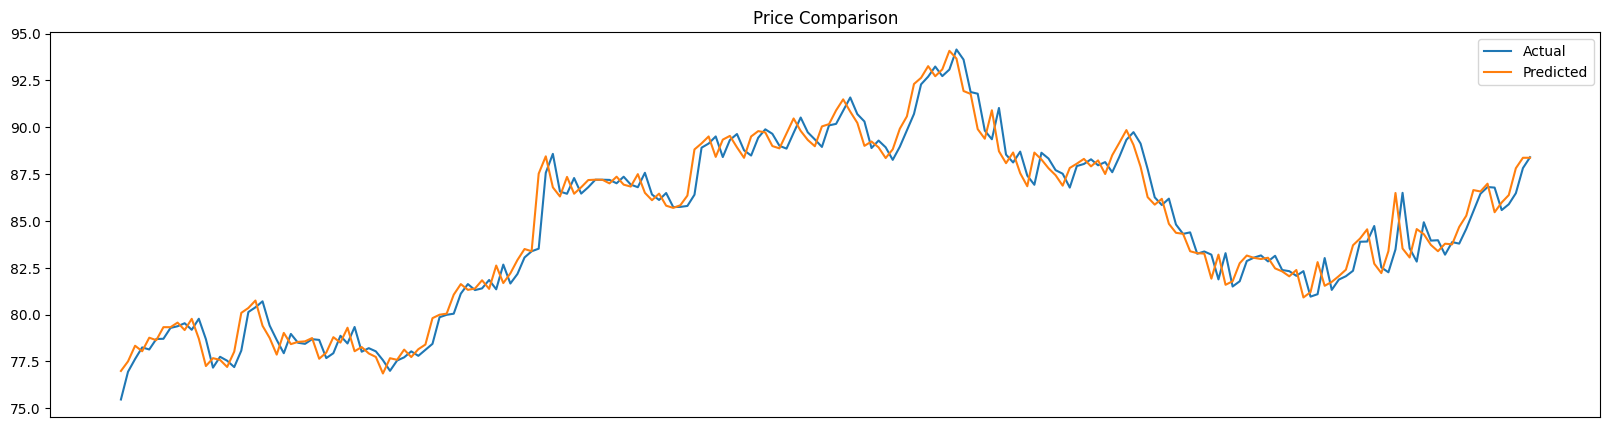

In [13]:
model = ARIMA(list(close), order=(2, 1, 3)) 
model_fit = model.fit()

predictions_close = model_fit.predict(start=2, end=len(close)+1)

plt.figure(figsize=(20,5))
plt.plot(close[-200:], label='Actual')
plt.plot(predictions_close[-200:], label='Predicted')
plt.xticks([])
plt.title('Price Comparison')
plt.legend()
plt.show()

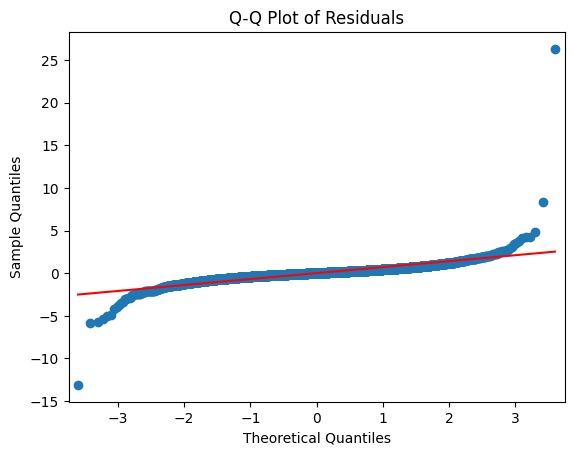

In [ ]:
residuals = model_fit.resid

sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

CONSTRUTING THE NEW DATAFRAME

In [ ]:
df_hist['date'] = df_hist.index

In [ ]:
add_sin_cos_transformation_method(df_hist)

df_hist.sin_cos_transformation(date_columns=['date'], periods=252) # 252 bussiness days in a year

df_hist.head()

,1. open,2. high,3. low,4. close,5. volume,day_sin_date,day_cos_date
2025-02-14,87.0200,87.4800,85.4800,85.5800,4391036,0.900969,0.433884
2025-02-13,86.7900,87.0300,86.0250,86.7800,4396341,0.889872,0.456211
2025-02-12,85.4600,86.8700,85.0000,86.8100,4723093,0.878222,0.478254
2025-02-11,85.2400,86.5300,84.2900,86.4500,4377032,0.866025,0.500000
2025-02-10,84.7000,85.5300,84.1800,85.5100,4141939,0.853291,0.521435


In [ ]:
df = pd.DataFrame({'closing_prices' : reversed(list(close)), 'next_day_forecast' : reversed(predictions_close), 
                   'volume': reversed(list(volume)), 
                   'day_sin': list(df_hist['day_sin_date']), 'day_cos': list(df_hist['day_cos_date'])}, index=df_hist.index)
df.head()

,closing_prices,next_day_forecast,volume,day_sin,day_cos
2025-02-14,85.58,85.579251,15.295076,0.900969,0.433884
2025-02-13,86.78,85.462202,15.296283,0.889872,0.456211
2025-02-12,86.81,86.990978,15.367974,0.878222,0.478254
2025-02-11,86.45,86.570453,15.291881,0.866025,0.500000
2025-02-10,85.51,86.646238,15.236675,0.853291,0.521435


CALCULATING THE MOVING AVERAGES FOR THE CLOSING PRICE AND VOLUME INDICATORS

In [ ]:
# The periods over which the the MAs are calculated
mean_values = [2,4,7,11,16,22,30]
volume_values = [2,4,7]


def closing_prices_MA(df, values, mean_values):
    for num in mean_values:
        rolling_mean = values.rolling(window=num).mean()[::-1]
        rolling_mean.index = df.index 
        df[f'mean_{num}'] = rolling_mean
    return df

def volume_MA(df, values, volume_values):
    for num in volume_values:
        rolling_mean = values.rolling(window=num).mean()[::-1]
        rolling_mean.index = df.index 
        df[f'vol_{num}'] = rolling_mean
    return df

df = closing_prices_MA(df, close, mean_values)
df = volume_MA(df, volume, volume_values)
df.dropna(inplace=True)
df.head()

,closing_prices,next_day_forecast,volume,day_sin,day_cos,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7
2025-02-14,85.58,85.579251,15.295076,0.900969,0.433884,86.180,86.4050,85.642857,84.953636,84.735625,84.336818,83.670333,15.295679,15.312804,15.278504
2025-02-13,86.78,85.462202,15.296283,0.889872,0.456211,86.795,86.3875,85.398571,84.894545,84.528125,84.176364,83.561667,15.332129,15.298203,15.270834
2025-02-12,86.81,86.990978,15.367974,0.878222,0.478254,86.630,85.8375,84.887143,84.535455,84.261875,83.953182,83.415000,15.329928,15.334247,15.280869
2025-02-11,86.45,86.570453,15.291881,0.866025,0.500000,85.980,85.0825,84.481429,84.238182,84.131875,83.703636,83.292667,15.264278,15.247549,15.318937
2025-02-10,85.51,86.646238,15.236675,0.853291,0.521435,85.045,84.4375,84.124286,84.242727,83.972500,83.547727,83.172333,15.338566,15.234925,15.328674


CALCULATING THE TARGET COLUMN

In [ ]:
previous_row_val = -1
df['Target'] = np.zeros(len(df))

for index, row in df.iterrows():
    if previous_row_val != -1:
        if previous_row_val > row['closing_prices']:
            df.loc[index, 'Target'] = 1

    previous_row_val = row['closing_prices']

df.head()

,closing_prices,next_day_forecast,volume,day_sin,day_cos,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7,Target
2025-02-14,85.58,85.579251,15.295076,0.900969,0.433884,86.180,86.4050,85.642857,84.953636,84.735625,84.336818,83.670333,15.295679,15.312804,15.278504,0.0
2025-02-13,86.78,85.462202,15.296283,0.889872,0.456211,86.795,86.3875,85.398571,84.894545,84.528125,84.176364,83.561667,15.332129,15.298203,15.270834,0.0
2025-02-12,86.81,86.990978,15.367974,0.878222,0.478254,86.630,85.8375,84.887143,84.535455,84.261875,83.953182,83.415000,15.329928,15.334247,15.280869,0.0
2025-02-11,86.45,86.570453,15.291881,0.866025,0.500000,85.980,85.0825,84.481429,84.238182,84.131875,83.703636,83.292667,15.264278,15.247549,15.318937,1.0
2025-02-10,85.51,86.646238,15.236675,0.853291,0.521435,85.045,84.4375,84.124286,84.242727,83.972500,83.547727,83.172333,15.338566,15.234925,15.328674,1.0


CALCULATING THE MODEL ACCURACY BASED SOLELY ON THE ARIMA FORECAST

In [ ]:
correct = 0
wrong = 0

for index, row in df.iterrows():
    if row['closing_prices']/row['next_day_forecast'] < 1:
        if row['Target'] == 1:
            correct+=1
        else:
            wrong+=1
    else:
        if row['Target'] == 0:
            correct+=1
        else:
            wrong+=1
            
starting_accuracy = correct/(correct + wrong)
print(f'Starting accuracy (based solely on the ARIMA forecast): ', starting_accuracy)

Starting accuracy (based solely on the ARIMA forecast):  0.9587873045949786


CALCULATING THE SURPLUS FOR EACH CALENDARISTIC DAY AND REPRESENT IT VISUALLY (SO AS TO SEE IF THERE IS ANY CORRELATION BETWEEN THE DATE AND THE PRICE MOVEMENT)

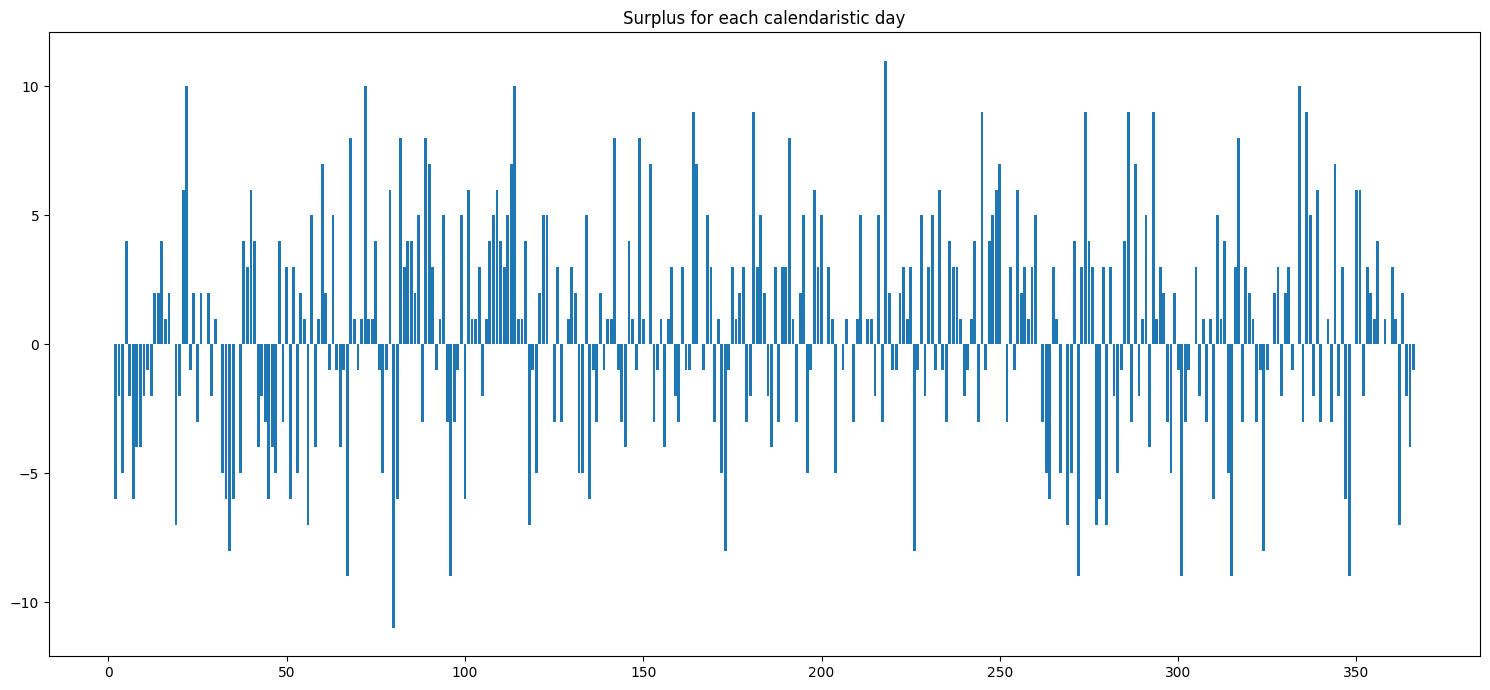

In [ ]:
month_day_freq: Dict[int, int] = {}

for index, row in df.iterrows():
    
    date_value = datetime.strptime(row.name, "%Y-%m-%d")

    day_of_year = date_value.timetuple().tm_yday

    if day_of_year not in month_day_freq:
        month_day_freq[day_of_year] = 0
    
    if row.Target == 1:
        month_day_freq[day_of_year] += 1
    else:
        month_day_freq[day_of_year] -= 1


plt.figure(figsize=(15, 7))
plt.bar(month_day_freq.keys(), month_day_freq.values())
plt.title("Surplus for each calendaristic day")
plt.tight_layout()



Text(0.5, 1.0, 'Percentage of days closing off higher or lower than in the previos day')

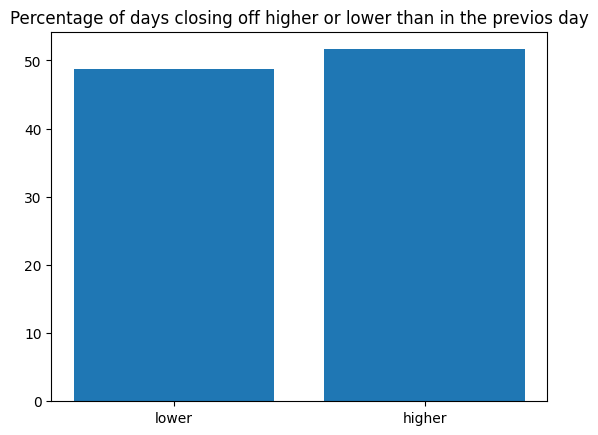

In [ ]:
df3 = df.groupby(by=['Target']).count()

plt.bar(df3.index, df3['closing_prices']/63.09)
plt.xticks(ticks=[0, 1], labels=['lower', 'higher'])
plt.title('Percentage of days closing off higher or lower than in the previos day')

In [ ]:
df['Target'] = df['Target'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6333 entries, 2025-02-14 to 1999-12-13
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   closing_prices     6333 non-null   float64 
 1   next_day_forecast  6333 non-null   float64 
 2   volume             6333 non-null   float64 
 3   day_sin            6333 non-null   float64 
 4   day_cos            6333 non-null   float64 
 5   mean_2             6333 non-null   float64 
 6   mean_4             6333 non-null   float64 
 7   mean_7             6333 non-null   float64 
 8   mean_11            6333 non-null   float64 
 9   mean_16            6333 non-null   float64 
 10  mean_22            6333 non-null   float64 
 11  mean_30            6333 non-null   float64 
 12  vol_2              6333 non-null   float64 
 13  vol_4              6333 non-null   float64 
 14  vol_7              6333 non-null   float64 
 15  Target             6333 non-null   category
d

In [ ]:
y = df['Target']
df.drop(columns='Target', inplace=True)

NORMALIZING THE MOVING AVERAGES

In [ ]:
col_to_div = ['closing_prices', 'next_day_forecast', 'mean_2', 'mean_4', 'mean_7', 'mean_11', 'mean_16', 'mean_22', 'mean_30']

df[col_to_div] = df[col_to_div].div(df['closing_prices'], axis=0)
df.drop(columns='closing_prices', inplace=True)

In [ ]:
col_to_div = ['vol_2', 'vol_4', 'vol_7']
df[col_to_div] = df[col_to_div].div(df['volume'], axis=0)

In [ ]:
row_to_predict = df.iloc[0, :]
df.drop(df.index[0], inplace=True)
df.head()

,next_day_forecast,volume,day_sin,day_cos,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7
2025-02-13,0.984815,15.296283,0.889872,0.456211,1.000173,0.995477,0.984081,0.978273,0.974051,0.969997,0.962914,1.002343,1.000126,0.998336
2025-02-12,1.002085,15.367974,0.878222,0.478254,0.997927,0.988797,0.977850,0.973799,0.970647,0.967091,0.960892,0.997524,0.997805,0.994332
2025-02-11,1.001393,15.291881,0.866025,0.500000,0.994563,0.984182,0.977229,0.974415,0.973185,0.968232,0.963478,0.998195,0.997101,1.001769
2025-02-10,1.013288,15.236675,0.853291,0.521435,0.994562,0.987458,0.983795,0.985180,0.982020,0.977052,0.972662,1.006687,0.999885,1.006038
2025-02-07,1.008284,15.440458,0.811938,0.583744,0.995330,0.991487,0.993632,0.993830,0.991620,0.985420,0.982431,0.986423,0.988791,0.996798


In [ ]:
X = df
y=y[1:]
row_to_predict = row_to_predict.to_frame().T

CHECKING FOR NULL VALUES

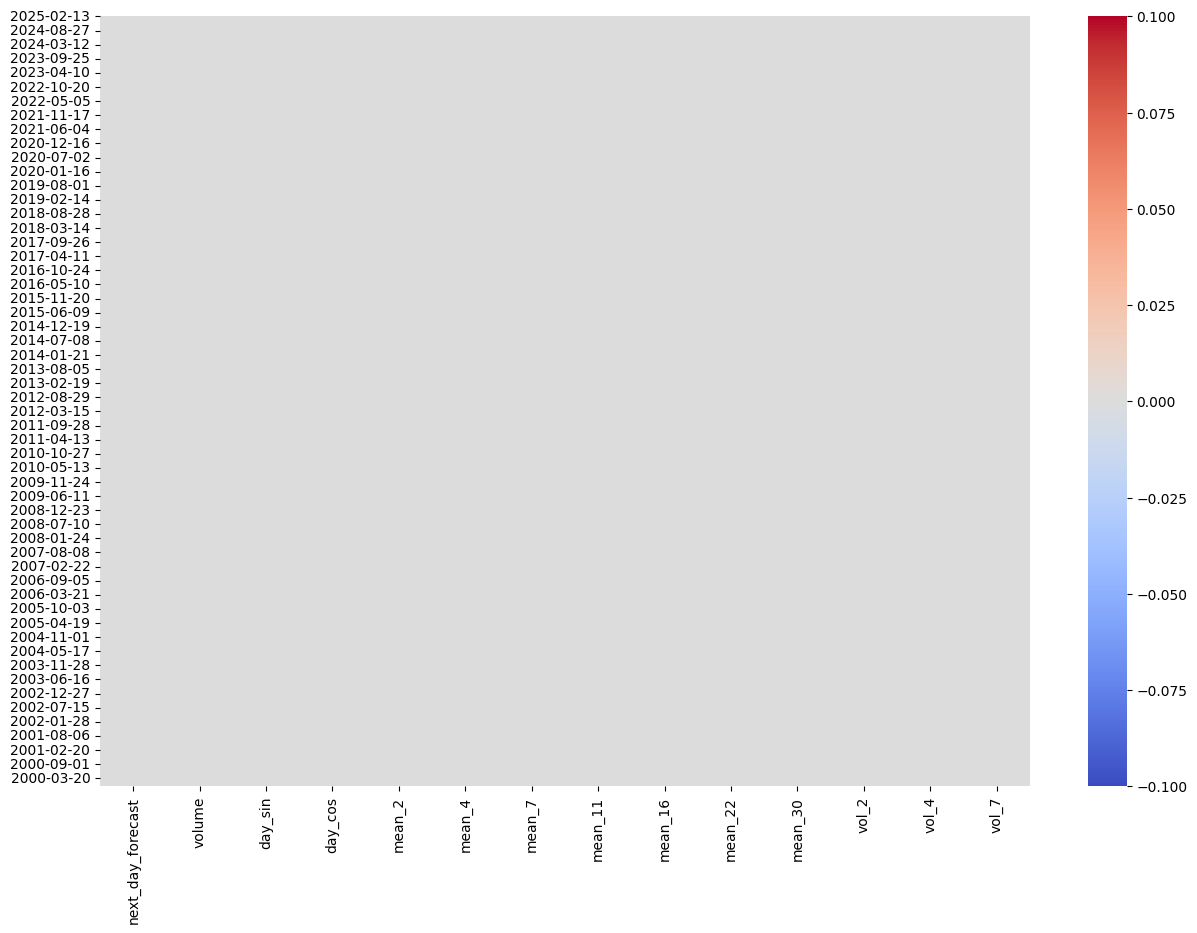

In [ ]:
add_null_values_method(X)

X.null_values()

In [ ]:
X.head()

,next_day_forecast,volume,day_sin,day_cos,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7
2025-02-13,0.984815,15.296283,0.889872,0.456211,1.000173,0.995477,0.984081,0.978273,0.974051,0.969997,0.962914,1.002343,1.000126,0.998336
2025-02-12,1.002085,15.367974,0.878222,0.478254,0.997927,0.988797,0.977850,0.973799,0.970647,0.967091,0.960892,0.997524,0.997805,0.994332
2025-02-11,1.001393,15.291881,0.866025,0.500000,0.994563,0.984182,0.977229,0.974415,0.973185,0.968232,0.963478,0.998195,0.997101,1.001769
2025-02-10,1.013288,15.236675,0.853291,0.521435,0.994562,0.987458,0.983795,0.985180,0.982020,0.977052,0.972662,1.006687,0.999885,1.006038
2025-02-07,1.008284,15.440458,0.811938,0.583744,0.995330,0.991487,0.993632,0.993830,0.991620,0.985420,0.982431,0.986423,0.988791,0.996798


In [ ]:
def grid_search_xgboost(X, y, param_grid):
    X = X.values
    y = y.values 

    param_combinations = (dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values()))

    max_accuracy = 0
    best_params = None
    best_num_boost_round = 0

    n_splits = 10
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    num_boost_round = 1500
    early_stopping_rounds = 20

    for params in param_combinations:
        try:
            fold_accuracies = []
            fold_boost_rounds = []

            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dtest = xgb.DMatrix(X_test, label=y_test)

                evals_result = {}

                model = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dtrain, 'train'), (dtest, 'test')],
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=False,
                    evals_result=evals_result
                )

                optimal_rounds = model.best_iteration
                fold_boost_rounds.append(optimal_rounds)

                y_pred_prob = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
                y_pred = (y_pred_prob > 0.5).astype(int)  
                accuracy = accuracy_score(y_test, y_pred)
                fold_accuracies.append(accuracy)

            mean_accuracy = np.mean(fold_accuracies)
            mean_boost_rounds = np.mean(fold_boost_rounds)

            if mean_accuracy > max_accuracy:
                max_accuracy = mean_accuracy
                best_params = params.copy()
                best_num_boost_round = int(mean_boost_rounds)

        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}")
            continue

    
    print(f"Best cross-validated accuracy achieved: {max_accuracy:.4f}")
    print(f"Optimal number of boosting rounds (trees): {best_num_boost_round}")
    print("Best parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")


AFTER SUCCESSIVE PARAMETER SEARCHES, THE BEST ACCURACY FOUND WAS 0.9610

NOW I AM LOOKING AT FEATURE INTERACTIONS: I TRY TO ADD ONE FEATURE AT A TIME TO SEE WHETHER IT IMPOVES THE MODEL ACCURACY OR NOT. 

FRIST I AM LOOKING AT PIRCE MOVING AVERAGES

In [ ]:

param_grid = {
    'max_depth': [7, 8],
    'learning_rate': [0.075, 0.08, 0.085],
    'subsample': [0.65, 0.7],
    'colsample_bytree': [0.8, 0.85], 
    'gamma': [6.5],
    'min_child_weight': [1],
    'objective': ['binary:logistic'],
    'tree_method': ['hist'],
    'device': ['cuda']
}



cX = X.copy()
cr = row_to_predict.copy()

for j in range(4,10):
    col = X.columns[j]
    for i in range(j+1,9):
        X = cX.copy()
        row_to_predict = cr.copy()
        X[f'{col}/{X.columns[i]}'] = X.iloc[:,j] / X.iloc[:,i]
        row_to_predict[f'{col}/{X.columns[i]}'] = row_to_predict.iloc[:,j] / row_to_predict.iloc[:,i]
        print(f'Prediction for {col}/{X.columns[i]}')
        grid_search_xgboost(X, y, param_grid)



Prediction for mean_2/mean_4
Best cross-validated accuracy achieved: 0.9610
Optimal number of boosting rounds (trees): 118
Best parameters:
max_depth: 7
learning_rate: 0.08
subsample: 0.65
colsample_bytree: 0.85
gamma: 6.5
min_child_weight: 1
objective: binary:logistic
tree_method: hist
device: cuda
Prediction for mean_2/mean_7
Best cross-validated accuracy achieved: 0.9610
Optimal number of boosting rounds (trees): 102
Best parameters:
max_depth: 7
learning_rate: 0.085
subsample: 0.65
colsample_bytree: 0.8
gamma: 6.5
min_child_weight: 1
objective: binary:logistic
tree_method: hist
device: cuda
Prediction for mean_2/mean_11
Best cross-validated accuracy achieved: 0.9608
Optimal number of boosting rounds (trees): 118
Best parameters:
max_depth: 7
learning_rate: 0.075
subsample: 0.7
colsample_bytree: 0.85
gamma: 6.5
min_child_weight: 1
objective: binary:logistic
tree_method: hist
device: cuda
Prediction for mean_2/mean_16
Best cross-validated accuracy achieved: 0.9611
Optimal number of b

SECONDLY, I AM LOOKING AT VOLUME VALUES MOVING AVERAGES

In [ ]:
param_grid = {
    'max_depth': [6, 7, 8],
    'learning_rate': [0.08, 0.085],
    'subsample': [0.65, 0.7],
    'colsample_bytree': [0.8, 0.85], 
    'gamma': [6.5],
    'min_child_weight': [1],
    'objective': ['binary:logistic'],
    'tree_method': ['hist'],
    'device': ['cuda']
}

cX = X.copy()
cr = row_to_predict.copy()

for j in range(11,13):
    col = X.columns[j]
    for i in range(j+1,14):
        X = cX.copy()
        row_to_predict = cr.copy()
        X[f'{col}/{X.columns[i]}'] = X.iloc[:,j] / X.iloc[:,i]
        row_to_predict[f'{col}/{X.columns[i]}'] = row_to_predict.iloc[:,j] / row_to_predict.iloc[:,i]
        print(f'Prediction for {col}/{X.columns[i]}')
        grid_search_xgboost(X, y, param_grid)

Prediction for vol_2/vol_4
Best cross-validated accuracy achieved: 0.9604
Optimal number of boosting rounds (trees): 118
Best parameters:
max_depth: 6
learning_rate: 0.08
subsample: 0.65
colsample_bytree: 0.8
gamma: 6.5
min_child_weight: 1
objective: binary:logistic
tree_method: hist
device: cuda
Prediction for vol_2/vol_7
Best cross-validated accuracy achieved: 0.9600
Optimal number of boosting rounds (trees): 129
Best parameters:
max_depth: 6
learning_rate: 0.08
subsample: 0.65
colsample_bytree: 0.85
gamma: 6.5
min_child_weight: 1
objective: binary:logistic
tree_method: hist
device: cuda
Prediction for vol_4/vol_7
Best cross-validated accuracy achieved: 0.9605
Optimal number of boosting rounds (trees): 110
Best parameters:
max_depth: 6
learning_rate: 0.085
subsample: 0.65
colsample_bytree: 0.8
gamma: 6.5
min_child_weight: 1
objective: binary:logistic
tree_method: hist
device: cuda


THE FOLLOWING FEATURE COMBINATIONS HAVE BEEN OBSERVED TO IMPROVE THE ACCURACY OF THE MODEL

In [ ]:
X['mean_4/7'] = X.loc[:,'mean_4'] / X.loc[:,'mean_7']
X['mean_4/11'] = X.loc[:,'mean_4'] / X.loc[:,'mean_11']
X['mean_4/16'] = X.loc[:,'mean_4'] / X.loc[:,'mean_16']
X['mean_2/16'] = X.loc[:,'mean_2'] / X.loc[:,'mean_16']

row_to_predict['mean_4/7'] = row_to_predict['mean_4'] / row_to_predict['mean_7']
row_to_predict['mean_4/11'] = row_to_predict['mean_4'] / row_to_predict['mean_11']
row_to_predict['mean_4/16'] = row_to_predict['mean_4'] / row_to_predict['mean_16']
row_to_predict['mean_2/16'] = row_to_predict['mean_2'] / row_to_predict['mean_16']

X.head()

,next_day_forecast,volume,day_sin,day_cos,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7,mean_4/7,mean_4/11,mean_4/16,mean_2/16
2025-02-13,0.984815,15.296283,0.889872,0.456211,1.000173,0.995477,0.984081,0.978273,0.974051,0.969997,0.962914,1.002343,1.000126,0.998336,1.011580,1.017586,1.021997,1.026818
2025-02-12,1.002085,15.367974,0.878222,0.478254,0.997927,0.988797,0.977850,0.973799,0.970647,0.967091,0.960892,0.997524,0.997805,0.994332,1.011196,1.015402,1.018699,1.028104
2025-02-11,1.001393,15.291881,0.866025,0.500000,0.994563,0.984182,0.977229,0.974415,0.973185,0.968232,0.963478,0.998195,0.997101,1.001769,1.007115,1.010023,1.011299,1.021967
2025-02-10,1.013288,15.236675,0.853291,0.521435,0.994562,0.987458,0.983795,0.985180,0.982020,0.977052,0.972662,1.006687,0.999885,1.006038,1.003723,1.002312,1.005538,1.012772
2025-02-07,1.008284,15.440458,0.811938,0.583744,0.995330,0.991487,0.993632,0.993830,0.991620,0.985420,0.982431,0.986423,0.988791,0.996798,0.997841,0.997642,0.999866,1.003741


I RETRAIN THE MODEL

In [ ]:
param_grid = {
    'max_depth': [7, 9, 12],
    'learning_rate': [0.07, 0.085, 0.1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1], 
    'gamma': [0, 3, 6],
    'min_child_weight': [0, 3, 6],
    'objective': ['binary:logistic'],
    'tree_method': ['hist'],
    'device': ['cuda']
}

grid_search_xgboost(X, y, param_grid)

Best cross-validated accuracy achieved: 0.9621
Optimal number of boosting rounds (trees): 115
Best parameters:
max_depth: 7
learning_rate: 0.1
subsample: 0.6
colsample_bytree: 0.6
gamma: 6
min_child_weight: 3
objective: binary:logistic
tree_method: hist
device: cuda


In [ ]:
param_grid = {
    'max_depth': [6, 7, 8],
    'learning_rate': [0.09, 0.1, 0.11],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.5, 0.6, 0.7], 
    'gamma': [5, 6, 7],
    'min_child_weight': [2, 3, 4],
    'objective': ['binary:logistic'],
    'tree_method': ['hist'],
    'device': ['cuda']
}

grid_search_xgboost(X, y, param_grid)

Best cross-validated accuracy achieved: 0.9621
Optimal number of boosting rounds (trees): 115
Best parameters:
max_depth: 7
learning_rate: 0.1
subsample: 0.6
colsample_bytree: 0.6
gamma: 6
min_child_weight: 3
objective: binary:logistic
tree_method: hist
device: cuda


Maximum accuracy: 0.961579


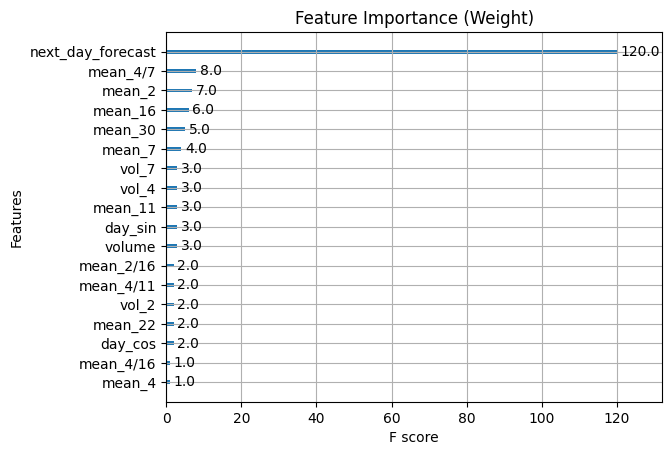

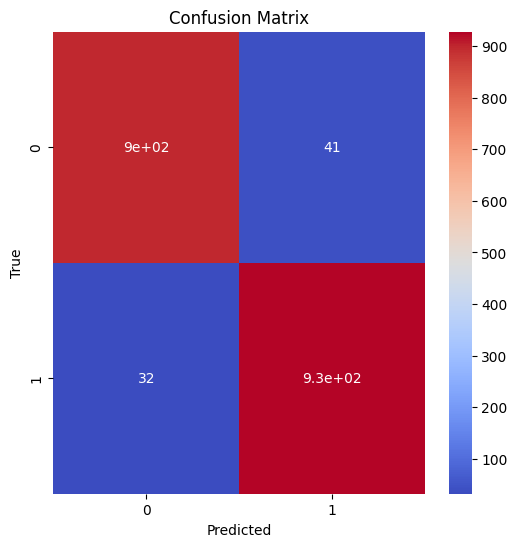

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

best_param = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'colsample_bytree': 0.6, 
    'gamma': 6,
    'min_child_weight': 3,
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'device': 'cuda'
}
num_boost_round = 115

train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(best_param, train_data, num_boost_round)

y_pred = (bst.predict(test_data) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Maximum accuracy: {accuracy:.6f}")

xgb.plot_importance(bst, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()

confusion_matrix(y_test, y_pred)

BEST ACCURACY OBTAINED: 0.961579

In [ ]:
dtrain = xgb.DMatrix(X, label=y)

final_model = xgb.train(
    best_param,
    dtrain,
    num_boost_round=115
)

dpredict = xgb.DMatrix(row_to_predict)

prediction_prob = final_model.predict(dpredict)

prediction = (prediction_prob > 0.5).astype(int)

print(f"Prediction Probability: {prediction_prob[0]:.4f}")
print(f"Binary Prediction: {prediction[0]}")

Prediction Probability: 0.3165
Binary Prediction: 0
